# Getting Started to Job Shop Lib

The main class of the library is the `JobShopInstance` class, which stores a list of jobs and its `Operations`.

Each operation is also a class, which stores the machine(s) in which the operation can be processed and its duration (also known as processing time). Let's see an example of how to use the `JobShopInstance` class to model a JSSP instance.

In this example, we model a simple Job Shop Scheduling Problem using the `JobShopInstance` class. We define three types of machines: CPU, GPU, and Data Center, each represented by a unique identifier.

In [1]:
from job_shop_lib import JobShopInstance, Operation

CPU = 0
GPU = 1
DATA_CENTER = 2

job_1 = [Operation(CPU, 1), Operation(GPU, 1), Operation(DATA_CENTER, 7)]
job_2 = [Operation(GPU, 5), Operation(DATA_CENTER, 1), Operation(CPU, 1)]
job_3 = [Operation(DATA_CENTER, 1), Operation(CPU, 3), Operation(GPU, 2)]

jobs = [job_1, job_2, job_3]

instance = JobShopInstance(
    jobs,
    name="Example",
    # Any extra parameters are stored inside the
    # metadata attribute as a dictionary:
    lower_bound=7,
)

The job and its position in it are automatically inferred. Now, we can access to some stats of the instance:

In [2]:
print("Number of jobs:", instance.num_jobs)
print("Number of machines:", instance.num_machines)
print("Number of operations:", instance.num_operations)
print("Name:", instance.name)
print("Is flexible?:", instance.is_flexible)
print("Max operation time:", instance.max_duration)
print("Machine loads:", instance.machine_loads)

Number of jobs: 3
Number of machines: 3
Number of operations: 9
Name: Example
Is flexible?: False
Max operation time: 7
Machine loads: [5, 8, 9]


In [3]:
import numpy as np

np.array(instance.durations_matrix)

array([[1, 1, 7],
       [5, 1, 1],
       [1, 3, 2]])

In [4]:
np.array(instance.machines_matrix)

array([[0, 1, 2],
       [1, 2, 0],
       [2, 0, 1]])

Some of this attributes could take $O(num\_operations)$ to compute. This is the reason we use the `functools.cached_property` decorator to cache the results of the computation of these attributes.

Note that we just had to specify the machines in which the operation can be processed and its duration. The `job_id` and the position of the operation in the job are automatically inferred by the `JobShopInstance` class.

In [5]:
first_operation = job_1[0]
print("Machine id:", first_operation.machine_id)
print("Duration:", first_operation.duration)
# If the operation only has one machine, we can use the `machine_id` property
# instead of the `machines` attribute:
print("Job id:", first_operation.job_id)
print("Position:", first_operation.position_in_job)
print("Operation id:", first_operation.id)
print("String representation:", str(first_operation))

Machine id: 0
Duration: 1
Job id: 0
Position: 0
Operation id: 0
String representation: O(m=0, d=1, j=0, p=0)


## How Solutions are Represented
A solution to the JSSP can be defined as a sequence of operations for each machine. The `Schedule` class maintains a list of `ScheduledOperations` for each machine, which stores the operation, the time it starts to be processed and the machine in which it is going to be processed.

The `Schedule` class is initialized with a `JobShopInstance`, which describes the JSSP you're working with. You can optionally pass a predefined schedule, a list of lists where each sublist represents the operations scheduled on a particular machine. In order to create a posible solution for this instance we can do it manually as follows:

First, the operations from the previous example are organized by their respective machines.

In [6]:
from job_shop_lib import ScheduledOperation, Schedule

cpu_operations = []
gpu_operations = []
data_center_operations = []

# Split the operations into three lists, one for each machine
for job in instance.jobs:
    for operation in job:
        if operation.machine_id == CPU:
            cpu_operations.append(operation)
        elif operation.machine_id == GPU:
            gpu_operations.append(operation)
        elif operation.machine_id == DATA_CENTER:
            data_center_operations.append(operation)

Note, that since each job does not have more than one operation for the same machine, we don't have to worry about the order of the operations in the list. However, we have to take into account the start time of each operation. In this case, we add to the last start time of the previous machine the maximum job duration of the instance. Of course, the solution will not be optimal, but it is a valid solution for the instance.

In [7]:
# Schedule the operations as they are ordered in the instance
def schedule_operations(operations, machine_id, start_time=0):
    machine_schedule = []
    for operation in operations:
        machine_schedule.append(
            ScheduledOperation(operation, start_time, machine_id)
        )
        start_time += 7

    return machine_schedule


cpu_schedule = schedule_operations(cpu_operations, CPU)
gpu_schedule = schedule_operations(gpu_operations, GPU, start_time=5)
data_center_schedule = schedule_operations(
    data_center_operations, DATA_CENTER, start_time=10
)

Now, we can create a `Schedule` object with the instance and the solution.

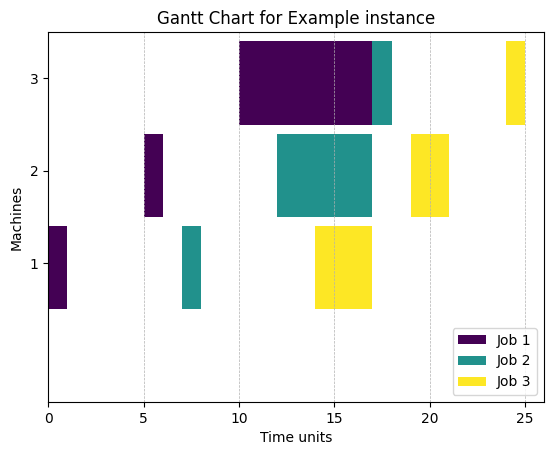

In [8]:
instance_schedule = [cpu_schedule, gpu_schedule, data_center_schedule]
schedule = Schedule(instance, instance_schedule)

fig, ax = schedule.plot_gantt_chart()

In [9]:
print(f"Is the schedule complete? {schedule.is_complete()}")

Is the schedule complete? True


## Solving the Problem
As you can see, manually creating solutions is a tedious task and requires taking into account each constraint carefully. This is the reason the `Dispatcher` class was created. This class allow us to just define the order in which operations are sequenced and the machines in which they are processed. The `Dispatcher` class will take care of the rest.

Let's see an example of how to use the `Dispatcher` class to solve the previous instance. In this case, a reasonable solution is to process the operations in the order they are defined in the instance. We can do this as follows:

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Gantt Chart for Example instance'}, xlabel='Time units', ylabel='Machines'>)

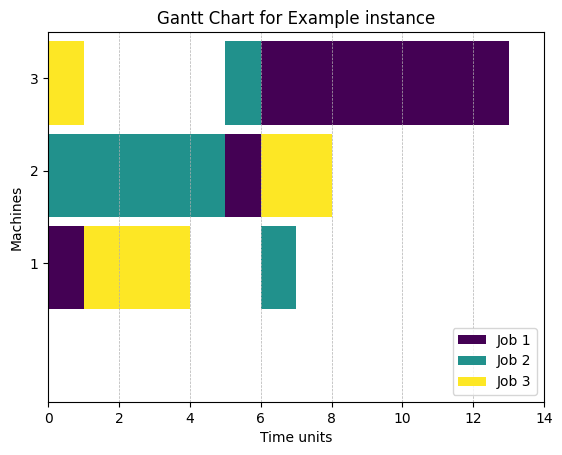

In [10]:
from job_shop_lib import Dispatcher

dispatcher = Dispatcher(instance)

for i in range(3):
    dispatcher.dispatch(job_1[i], job_1[i].machine_id)
    dispatcher.dispatch(job_2[i], job_2[i].machine_id)
    dispatcher.dispatch(job_3[i], job_3[i].machine_id)

dispatcher.schedule.plot_gantt_chart()


A solver is any `Callable` object that takes as input a `JobShopInstance` class and returns a `Schedule` with a complete solution of the instance.

In this example, we are going to use the `CPSolver` class, contained inside `job_shop_lib.solvers` package, which uses [CP-SAT solver from Google OR-Tools](https://developers.google.com/optimization/cp/cp_solver).

In [11]:
from job_shop_lib.solvers import CPSolver

solver = CPSolver()
schedule = solver(instance)
schedule.schedule

[[S-Op(operation=O(m=0, d=1, j=0, p=0), start_time=0, machine_id=0),
  S-Op(operation=O(m=0, d=3, j=2, p=1), start_time=1, machine_id=0),
  S-Op(operation=O(m=0, d=1, j=1, p=2), start_time=10, machine_id=0)],
 [S-Op(operation=O(m=1, d=1, j=0, p=1), start_time=1, machine_id=1),
  S-Op(operation=O(m=1, d=5, j=1, p=0), start_time=2, machine_id=1),
  S-Op(operation=O(m=1, d=2, j=2, p=2), start_time=7, machine_id=1)],
 [S-Op(operation=O(m=2, d=1, j=2, p=0), start_time=0, machine_id=2),
  S-Op(operation=O(m=2, d=7, j=0, p=2), start_time=2, machine_id=2),
  S-Op(operation=O(m=2, d=1, j=1, p=1), start_time=9, machine_id=2)]]

This class returns a `Schedule` object with a complete solution of the instance. It also set some metadata of the solution, such as the time it took to solve the instance and the status of the solution:

In [12]:
print(f"Is complete?: {schedule.is_complete()}")
print(f"Meta data: {schedule.metadata}")
print(f"Makespan: {schedule.makespan()}")

Is complete?: True
Meta data: {'status': 'optimal', 'elapsed_time': 0.007535126000220771, 'makespan': 11}
Makespan: 11


Finally, we can plot the gantt chart of the solution using the `plot_gantt_chart` method.

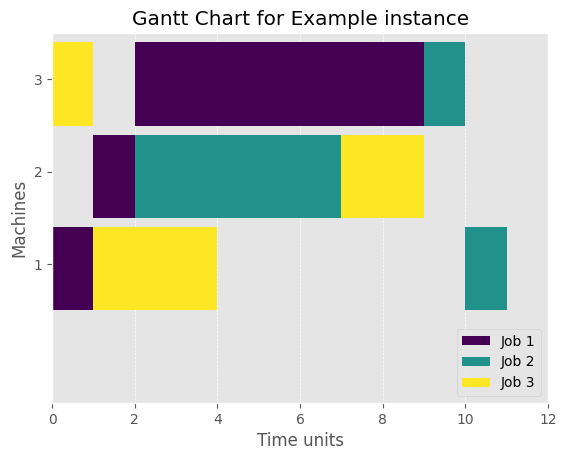

In [13]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

fig, ax = schedule.plot_gantt_chart()
plt.show()